--- Student-t Process回帰の実行例 ---

初期パラメータ:
log(σ_f): 0.0, log(l): 0.0, log(σ_n): -2.3025850929940455
ν: 5.0
初期の対数尤度: -62.67474302889549

ハイパーパラメータの最適化を開始します...
Iter     Function value   Gradient norm 
     0     6.267474e+01     1.441228e+01
 * time: 3.910064697265625e-5
     1     5.972112e+01     1.225715e+00
 * time: 0.00041794776916503906
     2     5.948758e+01     5.177496e-01
 * time: 0.0006561279296875
     3     5.910534e+01     2.019369e+00
 * time: 0.0009369850158691406
     4     5.636222e+01     1.145231e+01
 * time: 0.0012259483337402344
     5     5.632998e+01     1.191457e+01
 * time: 0.001683950424194336
     6     5.485540e+01     8.851001e+00
 * time: 0.0021381378173828125
     7     4.980730e+01     9.304944e+00
 * time: 0.006520986557006836
     8     4.666659e+01     3.069468e+00
 * time: 0.006707906723022461
     9     4.620457e+01     1.659971e+00
 * time: 0.006866931915283203
    10     4.607266e+01     4.210527e-01
 * time: 0.007079124450683594
    11     4.605

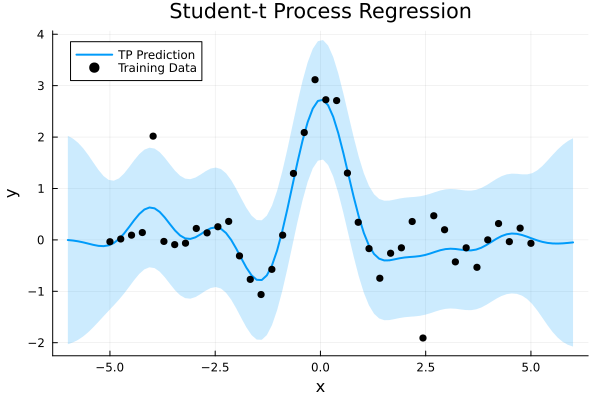

In [4]:
# ############################################################################
#
#   Julia Implementation of Student-t Process Regression
#   Based on: Shah et al. - 2014 - Student-t Processes as Alternatives
#             to Gaussian Processes
#   (Unicode-enhanced version for readability)
#
# ############################################################################

using Optim
using LinearAlgebra
using SpecialFunctions
using Distributions
using Plots
using Distances

# --- Kernel Function ---
# 論文の回帰実験では、二乗指数カーネルとデルタ（ノイズ）カーネルの和が使用されています。 

struct SquaredExponentialKernel end

"""
    kernel_matrix(k, X, params)

共分散行列Kを計算します。
ハイパーパラメータ `params` は [log_σ_f, log_l, log_σ_n] です。
"""
function kernel_matrix(::SquaredExponentialKernel, X::AbstractMatrix, params_θ::Vector{Float64})
    log_σ_f, log_l, log_σ_n = params_θ
    σ_f = exp(log_σ_f)
    l = exp(log_l)
    σ_n = exp(log_σ_n)

    sq_dist = pairwise(SqEuclidean(), X, dims=2)
    K_se = σ_f^2 * exp.(-0.5 * sq_dist / l^2)
    K = K_se + Diagonal(fill(σ_n^2 + 1e-6, size(X, 2))) # 安定性のためのジッター
    return K
end

"""
    kernel_matrix_grads(k, X, K, params_θ)

対数スケールのハイパーパラメータに関するカーネル行列Kの勾配を計算します。
"""
function kernel_matrix_grads(::SquaredExponentialKernel, X::AbstractMatrix, K::AbstractMatrix, params_θ::Vector{Float64})
    log_σ_f, log_l, log_σ_n = params_θ
    σ_f = exp(log_σ_f)
    l = exp(log_l)
    σ_n = exp(log_σ_n)

    n = size(X, 2)
    K_se = K - Diagonal(fill(σ_n^2 + 1e-6, n))

    ∂K_∂log_σ_f = 2 * K_se
    sq_dist = pairwise(SqEuclidean(), X, dims=2)
    ∂K_∂log_l = K_se .* sq_dist / l^2
    ∂K_∂log_σ_n = Diagonal(fill(2 * σ_n^2, n))

    return [∂K_∂log_σ_f, ∂K_∂log_l, ∂K_∂log_σ_n]
end


# --- Student-t Process Struct ---

mutable struct StudentTProcess
    X::Matrix{Float64}
    y::Vector{Float64}
    kernel::SquaredExponentialKernel
    params_θ::Vector{Float64} # [log_σ_f, log_l, log_σ_n]
    log_ν_minus_2::Float64    # ν > 2 を保証するために log(ν-2) を最適化

    function StudentTProcess(X, y; kernel=SquaredExponentialKernel(), init_params_θ=[0.0, 0.0, 0.0], init_ν=5.0)
        @assert init_ν > 2 "νは2より大きくなければなりません。" [cite: 52, 55, 80]
        new(X, y, kernel, init_params_θ, log(init_ν - 2))
    end
end

function get_ν(stp::StudentTProcess)
    return exp(stp.log_ν_minus_2) + 2
end

# --- Core Functions ---

"""
    log_marginal_likelihood(stp::StudentTProcess)

Student-t Processの対数周辺尤度を計算します。
この式は、論文の補足資料にあるEq. 5から導出されます。 
"""
function log_marginal_likelihood(stp::StudentTProcess)
    X, y = stp.X, stp.y
    n = length(y)
    ν = get_ν(stp)

    K = kernel_matrix(stp.kernel, X, stp.params_θ)
    C = cholesky(K)
    α = C \ y
    β = dot(y, α)
    log_det_K = logdet(C)

    lml = -n/2 * log((ν - 2) * π) - 0.5 * log_det_K +
          (loggamma((ν + n) / 2) - loggamma(ν / 2)) -
          ((ν + n) / 2) * log(1 + β / (ν - 2))

    return lml
end

"""
    gradient_log_marginal_likelihood(stp::StudentTProcess)

全ハイパーパラメータ [log_σ_f, log_l, log_σ_n, log(ν-2)] に関する対数周辺尤度の勾配を計算します。
"""
function gradient_log_marginal_likelihood(stp::StudentTProcess)
    X, y = stp.X, stp.y
    n = length(y)
    ν = get_ν(stp)

    K = kernel_matrix(stp.kernel, X, stp.params_θ)
    C = cholesky(K)
    K⁻¹ = inv(C)
    α = K⁻¹ * y
    β = dot(y, α)

    # --- カーネルハイパーパラメータθに関する勾配 ---
    # 補足資料の式を参照 
    ∂K_∂θ_list = kernel_matrix_grads(stp.kernel, X, K, stp.params_θ)
    grad_params_θ = zeros(length(stp.params_θ))
    common_term = ((ν + n) / (ν + β - 2)) * (α * α') - K⁻¹
    for i in 1:length(stp.params_θ)
        grad_params_θ[i] = 0.5 * tr(common_term * ∂K_∂θ_list[i])
    end

    # --- νに関する勾配 ---
    # 補足資料のEq. 15を参照 
    ∂lml_∂ν = -n / (2 * (ν - 2)) +
              0.5 * (digamma((ν + n) / 2) - digamma(ν / 2)) -
              0.5 * log(1 + β / (ν - 2)) +
              ((ν + n) * β) / (2 * (ν - 2)^2 + 2 * β * (ν - 2))
    
    grad_ν = ∂lml_∂ν * (ν - 2) # 連鎖律の適用

    return [grad_params_θ; grad_ν]
end

"""
    fit!(stp::StudentTProcess; max_iters=100)

対数周辺尤度を最大化することで、StudentTProcessモデルのハイパーパラメータを最適化します。
"""
function fit!(stp::StudentTProcess; max_iters=100)
    objective = p -> -log_marginal_likelihood(
        StudentTProcess(stp.X, stp.y; kernel=stp.kernel, init_params_θ=p[1:3], init_ν=exp(p[4])+2)
    )
    function gradient!(g, p)
        g[:] = -gradient_log_marginal_likelihood(
            StudentTProcess(stp.X, stp.y; kernel=stp.kernel, init_params_θ=p[1:3], init_ν=exp(p[4])+2)
        )
    end

    initial_params = [stp.params_θ; stp.log_ν_minus_2]
    result = optimize(objective, gradient!, initial_params, LBFGS(),
                      Optim.Options(iterations=max_iters, show_trace=true))

    optimized_params = Optim.minimizer(result)
    stp.params_θ = optimized_params[1:3]
    stp.log_ν_minus_2 = optimized_params[4]

    println("最適化が完了しました。")
    println("最終的な対数尤度: ", -Optim.minimum(result))
    println("最適化された log(σ_f): ", stp.params_θ[1])
    println("最適化された log(l):   ", stp.params_θ[2])
    println("最適化された log(σ_n): ", stp.params_θ[3])
    println("最適化された ν:        ", get_ν(stp))
end

"""
    predict(stp::StudentTProcess, X_new::AbstractMatrix)

新しい入力点 `X_new` に対する予測を行います。
予測平均と予測標準偏差を返します。この実装は条件付き分布の式、Eq. 6に従います。 
"""
function predict(stp::StudentTProcess, X_new::AbstractMatrix)
    X, y = stp.X, stp.y
    n = length(y)
    ν = get_ν(stp)

    K₁₁ = kernel_matrix(stp.kernel, X, stp.params_θ)
    sq_dist_21 = pairwise(SqEuclidean(), X_new, X, dims=2)
    K₂₁ = exp(stp.params_θ[1])^2 * exp.(-0.5 * sq_dist_21 / exp(stp.params_θ[2])^2)
    K₂₂ = kernel_matrix(stp.kernel, X_new, stp.params_θ)
    
    K₁₁⁻¹y = K₁₁ \ y
    μ_pred = K₂₁ * K₁₁⁻¹y
    
    β₁ = dot(y, K₁₁⁻¹y)
    K̃₂₂ = K₂₂ - K₂₁ * (K₁₁ \ K₂₁')
    scaling_factor = (ν + β₁ - 2) / (ν + n - 2)
    Σ_pred = scaling_factor * K̃₂₂
    
    σ_pred = sqrt.(abs.(diag(Σ_pred)))

    return μ_pred, σ_pred
end

# --- メイン関数（実行例） ---

function main()
    println("--- Student-t Process回帰の実行例 ---")

    n_train = 40
    X_train = reshape(collect(range(-5, 5, length=n_train)), 1, n_train)
    y_train = sinc.(X_train[1,:]) .* 3.0 + rand(Normal(0, 0.2), n_train)
    y_train[5] += 2.0; y_train[30] -= 2.5 # 外れ値を追加

    stp = StudentTProcess(X_train, y_train, init_params_θ=[0.0, 0.0, log(0.1)], init_ν=5.0)

    println("\n初期パラメータ:")
    println("log(σ_f): ", stp.params_θ[1], ", log(l): ", stp.params_θ[2], ", log(σ_n): ", stp.params_θ[3])
    println("ν: ", get_ν(stp))
    println("初期の対数尤度: ", log_marginal_likelihood(stp))

    println("\nハイパーパラメータの最適化を開始します...")
    fit!(stp, max_iters=200)

    n_test = 100
    X_test = reshape(collect(range(-6, 6, length=n_test)), 1, n_test)
    μ_pred, σ_pred = predict(stp, X_test)

    p = plot(title="Student-t Process Regression", xlabel="x", ylabel="y", legend=:topleft)
    plot!(p, X_test[1,:], μ_pred, ribbon=1.96 * σ_pred, fillalpha=0.2,
          linewidth=2, label="TP Prediction")
    scatter!(p, X_train[1,:], y_train, label="Training Data", markersize=4, markercolor=:black)
    display(p)
end

main()